<a href="https://colab.research.google.com/github/vivekverma1019/line-follower/blob/master/lf_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### import dependencies and preprocess data

##### import libraries and mount Gdrive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install tensorflow-addons

In [0]:
import tensorflow as tf
import numpy as np
import os
import json
import yaml
import time
import math
import cv2

In [0]:
tf.__version__

'2.0.0'

In [0]:
tf.debugging.set_log_device_placement(True)

In [0]:
import tensorflow_addons as tfa

In [0]:
tfa.__version__

'0.6.0'

In [0]:
tf.executing_eagerly()

True

In [0]:
os.getcwd()

'/content'

In [0]:
os.chdir('/content/drive/My Drive/Downloads/start_follow_read')

In [0]:
os.getcwd()

'/content/drive/My Drive/Downloads/start_follow_read'

##### read sample_config.yaml for configurations

In [0]:
with open('sample_config.yaml') as f:
    config = yaml.load(f)
pretrain_config = config['pretraining']

##### load_file_list() : return list of img filenames and corresponding json filenames

In [0]:
def load_file_list(config):
    file_list_path = config['file_list']
    with open(file_list_path) as f:
        data = json.load(f)
    for d in data:
        json_path = os.path.join(config['json_folder'], d[0])
        img_path = os.path.join(config['img_folder'], d[1])
        d[0] = json_path
        d[1] = img_path
    return data

##### json_state : return loaded json file

In [0]:
def json_state(path):
    for i in range(10):
        try:
            with open(path) as f:
                state = json.load(f)
            return state
        except:
            print("Failed to load",i,path)
            time.sleep(i)
            pass

    print("Failed to load state")
    return None

##### define detailed_ids = [(page_index , line_index)]

In [0]:
training_set_list = load_file_list(pretrain_config['training_set'])
ids = training_set_list
detailed_ids = []
for ids_idx , paths in enumerate(ids):
    json_path, img_path = paths
    d = json_state(json_path)
    if d is None:
        continue
    for i in range(len(d)):
        if 'lf' not in d[i]:
            continue
        detailed_ids.append((ids_idx , i))


#### training dataset

##### batch generator with batch_size = 1

In [0]:
def batch_gen():
    idx = np.random.randint(low=0,high=len(detailed_ids))

    ids_idx, line_idx = detailed_ids[idx]
    gt_json_path , img_path = ids[ids_idx]
    gt_json = json_state(gt_json_path)

    positions = []
    positions_xy = []
    # if 'lf' not in gt_json[line_idx]:
    #     return None

    for step in gt_json[line_idx]['lf']:
        x0 = step['x0']
        x1 = step['x1']
        y0 = step['y0']
        y1 = step['y1']

        positions_xy.append((tf.convert_to_tensor([[x1,x0],[y1,y0]])))
        dx = x0-x1
        dy = y0-y1
        d = math.sqrt(dx**2 + dy**2)
        mx = (x0+x1)/2.0
        my = (y0+y1)/2.0
        theta = -math.atan2(dx, -dy)
        positions.append(tf.convert_to_tensor([mx, my, theta, d/2, 1.0]))
    #positions  = [tf.convert_to_tensor(x_i) for i,x_i in enumerate(positions[i,:])]
    img = cv2.imread(img_path)

    img = img.astype(np.float32)
    img = img.transpose()
    img = img / 128.0 - 1.0
    img = np.expand_dims(img , 0)
    gt = gt_json[line_idx]['gt']
    positions = [x_i[None,...] for x_i in positions]
    positions_xy = [x_i[None,...] for x_i in positions_xy]
    result = {
        "img": img,
        "lf_xyrs": positions,
        "lf_xyxy": positions_xy,
        "gt": gt
    }
    yield result

##### initialize tf.data.Dataset instance

In [0]:
dataset = tf.data.Dataset.from_generator(batch_gen, output_types={'img':tf.float32,
                                                                  'lf_xyrs':tf.float32,
                                                                  'lf_xyxy':tf.float32,
                                                                  'gt':tf.string})

Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0


In [0]:
for data in dataset:
    data

Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNextSync in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0


In [0]:
data['img'].shape, len(data['lf_xyrs']) , len(data['lf_xyxy'])

(TensorShape([1, 3, 1169, 1440]), 18, 18)

In [0]:
data['lf_xyrs'][0] , data['lf_xyxy'][-1]

(<tf.Tensor: id=1158, shape=(1, 5), dtype=float32, numpy=
 array([[ 2.1980972e+02,  4.8480276e+02, -1.3843756e-02,  2.5645493e+01,
          1.0000000e+00]], dtype=float32)>,
 <tf.Tensor: id=1162, shape=(1, 2, 2), dtype=float32, numpy=
 array([[[1119.4426 , 1120.1526 ],
         [ 522.90564,  471.61963]]], dtype=float32)>)

##### a glance at the data instance

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(b'eist seyn soll,)', shape=(), dtype=string)


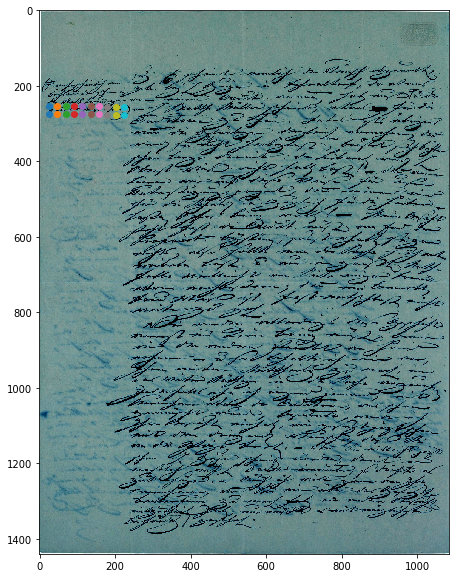

In [0]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14,10))
print(data['gt'])
plt.imshow(np.transpose(np.squeeze(data['img'], axis=0),(2,1,0)))
for i in np.squeeze(data['lf_xyxy'], axis=1):
    plt.scatter(i[0] , i[1])


#### validation_loss()

In [0]:
def validation_loss():
    validation_set_list = load_file_list(pretrain_config['validation_set'])
    ids = validation_set_list
    detailed_ids = []
    for ids_idx , paths in enumerate(ids):
        json_path, img_path = paths
        d = json_state(json_path)
        if d is None:
            continue
        for i in range(len(d)):
            if 'lf' not in d[i]:
                continue
            detailed_ids.append((ids_idx , i))
    sum_loss = 0.0
    steps = 0.0
    for idx in range(len(detailed_ids)):
        ids_idx, line_idx = detailed_ids[idx]
        print("ids_idx, line_idx : {} {}".format(ids_idx, line_idx))
        gt_json_path , img_path = ids[ids_idx]
        gt_json = json_state(gt_json_path)
        positions = []
        positions_xy = []
        # if 'lf' not in gt_json[line_idx]:
        #     return None

        for step in gt_json[line_idx]['lf']:
            x0 = step['x0']
            x1 = step['x1']
            y0 = step['y0']
            y1 = step['y1']

            positions_xy.append((tf.convert_to_tensor([[x1,x0],[y1,y0]])))
            dx = x0-x1
            dy = y0-y1
            d = math.sqrt(dx**2 + dy**2)
            mx = (x0+x1)/2.0
            my = (y0+y1)/2.0
            theta = -math.atan2(dx, -dy)
            positions.append(tf.convert_to_tensor([mx, my, theta, d/2, 1.0]))
        img = cv2.imread(img_path)
        img = img.astype(np.float32)
        img = img.transpose()
        img = img / 128.0 - 1.0
        img = np.expand_dims(img , 0)
        gt = gt_json[line_idx]['gt']
        positions = [x_i[None,...] for x_i in positions]
        positions_xy = [x_i[None,...] for x_i in positions_xy]
        result = {
            "img": img,
            "lf_xyrs": positions,
            "lf_xyxy": positions_xy,
            "gt": gt
        }
        grid_line, _, _, xy_output = line_follower(result['img'], positions[:1], steps=len(positions), skip_grid=True)
        loss = point_loss(xy_output, xy_positions= result['lf_xyxy'])
        sum_loss += loss
        steps += 1

    return sum_loss / steps

#### creating model class: LineFollower(tf.keras.Model)

In [0]:
class LineFollower(tf.keras.Model):
    def __init__(self, output_grid_size=32):
        super(LineFollower, self).__init__()
        cnn = makeCnn()
        position_linear = tf.keras.layers.Dense(5,kernel_initializer=tf.keras.initializers.Zeros(), bias_initializer=tf.keras.initializers.Zeros())
        self.output_grid_size = output_grid_size
        self.cnn = cnn
        self.position_linear = position_linear

    def call(self, image, positions, steps=None, all_positions=[], reset_interval=-1, randomize=False, negate_lw=False, skip_grid=False, allow_end_early=False):
        batch_size = image.shape[0]
        renorm_matrix = compute_renorm_matrix(image)
        expanded_renorm_matrix = tf.expand_dims(renorm_matrix , axis=0)
        t = ((tf.range(self.output_grid_size, dtype = tf.float32) + 0.5) / float(self.output_grid_size))[:,None] #.astype(np.float32)
        #t = np.repeat(t,axis=1, repeats= self.output_grid_size)
        t = tf.keras.backend.repeat_elements(t , rep = self.output_grid_size , axis = 1)
        s = tf.transpose(t)
        t = t[:,:,None]
        s = s[:,:,None]
        interpolations = tf.convert_to_tensor( tf.concat([
            (1-t)*s,
            (1-t)*(1-s),
            t*s,
            t*(1-s),], -1) ,  dtype = tf.float32)
        view_window = tf.expand_dims(tf.convert_to_tensor([
            [2,0,2],
            [0,2,0],
            [0,0,1]] , dtype = tf.float32),0) 
        step_bias = tf.expand_dims(tf.convert_to_tensor([
                    [1,0,2],
                    [0,1,0],
                    [0,0,1]]  ,dtype = tf.float32) , 0)
        invert = tf.expand_dims(tf.convert_to_tensor([
            [-1,0,0],
            [0,-1,0],
            [0,0,1]] , dtype = tf.float32) ,0)

        if negate_lw:
            view_window = tf.linalg.matmul(invert , view_window)
        grid_gen = GridGen(32,32)
        view_window_imgs = []
        next_windows = []
        reset_windows = True
        for i in range(steps):
            #print("=>"*15)
            if i%reset_interval != 0 or reset_interval==-1:
                p_0 = positions[-1]
                #print("p_0 : {}".format(p_0))
                if i == 0 and len(p_0.shape) == 3 and p_0.shape[1] == 3 and p_0.shape[2] == 3:
                    current_window = p_0
                    reset_windows = False
                    next_windows.append(p_0)
                    #print("current window : {}".format(current_window))
            else:
                p_0 = all_positions[i]
                reset_windows = True
                if randomize:
                    # add_noise = tf.zeros_like(p_0 , dtype = tf.float32)
                    mul_noise = tf.ones_like(p_0 , dtype = tf.float32)
                    add_noise = tf.stack([tf.random.uniform(shape = [1,], minval = -2 , maxval = 2)[0],
                                          tf.random.uniform(shape = [1,], minval = -2 , maxval = 2)[0],
                                          tf.random.uniform(shape = [1,], minval = -0.1 , maxval = 0.1)[0],
                                          0.0,
                                          0.0] , axis = 0)
                    # add_noise[:,0] = tf.random.uniform(shape = [1,], minval = -2 , maxval = 2)[0]
                    # add_noise[:,1] = tf.random.uniform(shape = [1,], minval = -2 , maxval = 2)[0]
                    # add_noise[:,2] = tf.random.uniform(shape = [1,], minval = -0.1 , maxval = 0.1)[0]
                    p_0 = p_0 * mul_noise + add_noise
                    #print("p_0 : {}".format(p_0))

            if reset_windows:
                reset_windows = False
                current_window = get_init_matrix(p_0)
                if len(next_windows) == 0:
                    next_windows.append(current_window)
            else:
                current_window = next_windows[-1]

            crop_window = tf.linalg.matmul(current_window , view_window)
            # print("image shape : {}".format(image.shape))
            #print("crop_window : {}".format(crop_window))
            resampled = get_patches(image, crop_window, grid_gen, allow_end_early)

            #print("resampled : {}".format(resampled))
            if resampled is None and i > 0:
                break

            if resampled is None and i == 0:
                resampled = tf.Variable(tf.zeros((crop_window.shape[0] , 3 , 32 , 32) , dtype = tf.float32))

            # Process Window CNN
            cnn_out = self.cnn(resampled)
            cnn_out = tf.squeeze(cnn_out, axis=2)
            cnn_out = tf.squeeze(cnn_out, axis=2)
            delta = self.position_linear(cnn_out)
            next_window = get_step_matrix(delta)
            next_window = tf.linalg.matmul(next_window , step_bias)
            if negate_lw:
                next_window = tf.linalg.matmul(invert , tf.linalg.matmul(next_window , invert))

            next_windows.append( tf.linalg.matmul(current_window ,next_window))
        #print(next_windows)
        grid_line = []
        mask_line = []
        line_done = []
        xy_positions = []
        a_pt = tf.Variable([[0, 1,1],
                          [0,-1,1]
                       ] , dtype = tf.float32)
        a_pt = tf.transpose(a_pt , perm = (1,0))
        a_pt = tf.expand_dims(a_pt , 0)

        for i in range(0, len(next_windows)-1):

            w_0 = next_windows[i]
            w_1 = next_windows[i+1]
            pts_0 = tf.linalg.matmul(w_0 , a_pt) 
            pts_1 = tf.linalg.matmul(w_1 , a_pt) 
            xy_positions.append(pts_0)

            if skip_grid:
                continue

            pts = tf.concat((pts_0, pts_1), axis=2)
            grid_pts = tf.linalg.matmul(expanded_renorm_matrix , pts)
            grid = interpolations[None,:,:,None,:] * grid_pts[:,None,None,:,:]
            grid = tf.math.reduce_sum(grid , axis = -1)[...,:2] 
            grid_line.append(grid)

        xy_positions.append(pts_1)

        if skip_grid:
            grid_line = None
        else:
            grid_line = tf.concat(grid_line, axis=1)

        return grid_line, view_window_imgs, next_windows, xy_positions 

#### *Execute main after running all the cells below main*
#### main

In [0]:
line_follower = LineFollower()

In [0]:
# for i in dataset:
#     data = i
print(data['gt'])
img = data['img']
positions = data['lf_xyrs']
xy_positions = data['lf_xyxy']
reset_interval = 4
grid_line, _, _, xy_output = line_follower(img, positions[:1], steps=len(positions), all_positions=positions,
                                            reset_interval=reset_interval, randomize=True, skip_grid=True)
loss = point_loss(xy_positions,xy_output)
loss

tf.Tensor(b'einleiten. \xe2\x80\x93 Da\xc3\x9f man in Fraufeld diese Anerbietungen', shape=(), dtype=string)


<tf.Tensor: id=22656401, shape=(), dtype=float32, numpy=445.52435>

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon = 1e-08)
train_loss_history = []
def train_step(data):
    img = data['img']
    positions = data['lf_xyrs']
    xy_positions = data['lf_xyxy']
    with tf.GradientTape() as tape:
        grid_line, _, _, xy_output = line_follower(img, positions[:1], steps=len(positions), all_positions=positions,
                                            reset_interval=reset_interval, randomize=True, skip_grid=True,training=True)
        loss_value = point_loss(xy_positions, xy_output)
    train_loss_history.append(loss_value)
    grads = tape.gradient(loss_value, line_follower.trainable_variables)
    print(grads)
    optimizer.apply_gradients(zip(grads, line_follower.trainable_variables))

In [0]:
import time
import os
def train(epochs):
    if os.path.exists('/content/drive/My Drive/lf_tf.h5'):
        print("Loading best saved model ...")
        line_follower.load_weights('/content/drive/My Drive/lf_tf.h5')
        print('Validation Loss : {}'.format(validation_loss()))
        print("Loaded :-)")
        lowest_loss = validation_loss()
    else:
        lowest_loss = np.inf
    cnt_since_last_improvement = 0  
    for epoch in range(epochs):
        st = time.time()
        for (batch, data) in enumerate(dataset.repeat(1000)):
            print("==> Epoch : {} , Batch : {}".format(epoch , batch))
            sta = time.time()
            train_step(data)
            print("Time taken: {} sec. , ETA : {} sec".format(time.time() - sta  , (time.time() - sta) * (1000 - batch + 1)))
        print ('Epoch {} finished'.format(epoch))
        print("Time taken by Epoch {} : {} seconds".format(epoch , time.time() - st))
        print("Validation Loss : {}".format(validation_loss()))
        cnt_since_last_improvement += 1
        if lowest_loss > validation_loss():
            cnt_since_last_improvement = 0
            lowest_loss = validation_loss()
            print("Saving Best")
            model.save('/content/drive/My Drive/lf_tf.h5')
        if cnt_since_last_improvement >= 10:
            break

In [0]:
initial_time = time.time()
train(epochs = 1000)
print("Total time : {}".format(time.time() - initial_time))

#### point_loss()

In [0]:
def point_loss(xy_positions,xy_output):
    mse = tf.keras.losses.MeanSquaredError()
    loss = 0
    for i , l in enumerate(xy_positions):
        loss += mse(y_true = l , y_pred= xy_output[i][:,:2,:2])
    return loss

#### get_patches()

In [0]:
def get_patches(image, crop_window, grid_gen, allow_end_early=False):
        pts = tf.convert_to_tensor([
            [-1.0, -1.0, 1.0, 1.0],
            [-1.0, 1.0, -1.0, 1.0],
            [ 1.0, 1.0,  1.0, 1.0]
        ] , dtype = tf.float32 )[None,...]

        bounds = tf.linalg.matmul(crop_window , pts)
        min_bounds = tf.math.reduce_min(bounds , axis = -1)
        max_bounds = tf.math.reduce_max(bounds , axis = -1)
        d_bounds = max_bounds - min_bounds
        floored_idx_offsets = tf.math.floor(min_bounds[:,:2]) 
        max_d_bounds = tf.math.reduce_max(d_bounds) 
        crop_size = tf.math.ceil(max_d_bounds)
        w = tf.dtypes.cast(crop_size, dtype = tf.int32)
        memory_space = np.zeros((d_bounds.shape[0] , 3, w ,w) , dtype = np.float32)
        translations = []
        N = compute_renorm_matrix(memory_space)
        all_skipped = True

        for b_i in range(memory_space.shape[0]):

            o = tf.dtypes.cast(floored_idx_offsets[b_i] , dtype = tf.int32)

            t = tf.convert_to_tensor([
                [1,0,-o[0]],
                [0,1,-o[1]],
                [0,0,    1]
            ] , dtype = tf.float32 )

            translations.append(tf.linalg.matmul(N, t)[None,...])
            skip_slice = False

            s_x = (o[0], o[0]+w)
            s_y = (o[1], o[1]+w)
            t_x = (0, w)
            t_y = (0, w)
            if o[0] < 0:
                s_x = (0, w+o[0])
                t_x = (-o[0], w)

            if o[1] < 0:
                s_y = (0, w+o[1])
                t_y = (-o[1], w)

            if o[0]+w >= image.shape[2]:
                s_x = (s_x[0], image.shape[2])
                t_x = (t_x[0], image.shape[2] - s_x[0])

            if o[1]+w >= image.shape[3]:
                s_y = (s_y[1], image.shape[3])
                t_y = (t_y[1], image.shape[3] - s_y[1])

            if s_x[0] >= s_x[1]:
                skip_slice = True

            if t_x[0] >= t_x[1]:
                skip_slice = True

            if s_y[0] >= s_y[1]:
                skip_slice = True

            if t_y[0] >= t_y[1]:
                skip_slice = True

            if not skip_slice:
                all_skipped = False
                i_s  = image[b_i:b_i+1, :, s_x[0]:s_x[1], s_y[0]:s_y[1]]
                memory_space[b_i:b_i+1, :, t_x[0]:t_x[1], t_y[0]:t_y[1]] = i_s

        if all_skipped and allow_end_early:
            return None
        translations = tf.concat(translations, 0)
        grid = grid_gen(tf.linalg.matmul(translations , crop_window))
        grid = grid[:,:,:,0:2] / grid[:,:,:,2:3]

        resampled = grid_sample(ip = np.transpose(memory_space , (0,1,3,2)) , grd = grid)
        return resampled


#### grid_sample()

In [0]:
def grid_sample(ip, grd):
    N = ip.shape[0]
    C = ip.shape[1]
    IH = ip.shape[2]
    IW = ip.shape[3]
    H = grd.shape[1]
    W = grd.shape[2]
    output = np.zeros((N,C,H,W))
    for n in range(N):
        for h in range(H):
            for w in range(W):
                ix = grd[n,h,w,0]
                iy = grd[n,h,w,1]

                ix = (( ix+1 ) / 2) * (IW - 1)
                iy = ((iy + 1) / 2) * (IH - 1)

                ix_nw = math.floor(ix)
                iy_nw = math.floor(iy)
                ix_ne = ix_nw + 1
                iy_ne = iy_nw
                ix_sw = ix_nw
                iy_sw = iy_nw + 1
                ix_se = ix_nw + 1
                iy_se = iy_nw + 1

                nw = (ix_se - ix)    * (iy_se - iy)
                ne = (ix    - ix_sw) * (iy_sw - iy)
                sw = (ix_ne - ix)    * (iy    - iy_ne)
                se = (ix    - ix_nw) * (iy    - iy_nw)

                for c in range(C):
                    nw_val = SAFE_GET(ip, ix_nw, iy_nw, n, c, IH, IW)
                    ne_val = SAFE_GET(ip, ix_ne, iy_ne, n, c, IH, IW)
                    sw_val = SAFE_GET(ip, ix_sw, iy_sw, n, c, IH, IW)
                    se_val = SAFE_GET(ip, ix_se, iy_se, n, c, IH, IW)
                    out_val = nw_val * nw + ne_val * ne + sw_val * sw + se_val * se
                    output[n, c, h, w] = out_val
                    
    return tf.convert_to_tensor(output, dtype = tf.float32)

#### SAFE_GET()

In [0]:
def SAFE_GET(ip, x ,y , n , c, H, W):
    if x >= 0 and x < W and y >=0 and y < H:
        return ip[n,c,y,x]
    else:
        return 0.0

#### get_step_matrix()

In [0]:
def get_step_matrix(input):
    output = tf.Variable(initial_value= tf.zeros(shape = (tf.shape(input)[0],3,3) ), dtype = tf.float32)

    output[:,0,0].assign(tf.ones(shape=(tf.shape(output)[0],)))
    output[:,1,1].assign(tf.ones(shape=(tf.shape(output)[0],)))
    output[:,2,2].assign(tf.ones(shape=(tf.shape(output)[0],)))

    x = input[:,0:1]
    y = input[:,1:2]
    angles = input[:,2:3]

    cosines = tf.math.cos(angles)
    sinuses = tf.math.sin(angles)

    output[:,0,0].assign(tf.squeeze(cosines , axis = 0))
    output[:,1,1].assign(tf.squeeze(cosines , axis = 0))
    output[:,1,0].assign(tf.squeeze(-sinuses , axis = 0))
    output[:,0,1].assign(tf.squeeze(sinuses , axis = 0))

    output[:,0,2].assign(tf.squeeze(x , axis = 0))
    output[:,1,2].assign(tf.squeeze(y , axis = 0))
    return output

#### get_init_matrix()

In [0]:
def get_init_matrix(input):
    output = tf.Variable(initial_value= tf.zeros(shape = (tf.shape(input)[0],3,3) ), dtype = tf.float32)
    output[:,0,0].assign(tf.ones(shape=(tf.shape(output)[0],)))
    output[:,1,1].assign(tf.ones(shape=(tf.shape(output)[0],)))
    output[:,2,2].assign(tf.ones(shape=(tf.shape(output)[0],)))

    x = input[:,0:1]
    y = input[:,1:2]
    angles = input[:,2:3]
    scaler = input[:,3:4]

    cosines = tf.math.cos(angles)
    sinuses = tf.math.sin(angles)
    output[:,0,0].assign(tf.squeeze(cosines * scaler , axis = 0))
    output[:,1,1].assign(tf.squeeze(cosines * scaler , axis = 0))
    output[:,1,0].assign(tf.squeeze(-sinuses * scaler, axis = 0))
    output[:,0,1].assign(tf.squeeze(sinuses * scaler, axis = 0))

    output[:,0,2].assign(tf.squeeze(x , axis = 0))
    output[:,1,2].assign(tf.squeeze(y , axis = 0))

    return output

#### compute_renorm_matrix()

In [0]:
def compute_renorm_matrix(img):
    inv_c = tf.convert_to_tensor(np.array([
        [1.0/img.shape[2], 0, 0],
        [0, 1.0/img.shape[3], 0],
        [0,0,1] 
    ], dtype=np.float32), dtype = tf.float32)

    inv_b = tf.convert_to_tensor(np.array([
        [2,0,-1],
        [0,2,-1],
        [0,0, 1]
    ], dtype= np.float32) , dtype = tf.float32)
    return tf.linalg.matmul(inv_b,inv_c)


#### GridGen()

In [0]:
class GridGen():
    def __init__(self, height, width):
        super(GridGen, self).__init__()
        self.height, self.width = height, width
        #self.grid = tf.zeros( [self.height, self.width, 3], dtype=tf.float32)
        grid_space_h = (tf.range(self.height , dtype = tf.float32) + 0.5) / float(self.height)
        grid_space_w = (tf.range(self.width , dtype = tf.float32) + 0.5) / float(self.width)
        grid_space_h = 2 * grid_space_h - 1
        grid_space_w = 2 * grid_space_w - 1
        self.grid = tf.stack([tf.transpose(tf.keras.backend.repeat_elements(tf.expand_dims(grid_space_h, 0), rep = self.width, axis = 0)),
                              tf.keras.backend.repeat_elements(tf.expand_dims(grid_space_w, 0), rep = self.height, axis = 0),
                              tf.ones([self.height, width] , dtype = tf.float32) ] , axis = 2)
    def __call__(self, input):
        out = tf.linalg.matmul(tf.convert_to_tensor(input[:,None,None,:,:], dtype = tf.float32) , self.grid[None,:,:,:,None] )
        out = tf.squeeze(out, axis=-1)
        return out

#### makeCnn()

In [0]:

def makeCnn():
    cnn = tf.keras.Sequential()
    cnn.add(tf.keras.layers.Conv2D(64,kernel_size=3,padding='same', data_format='channels_first'))
    cnn.add(tf.keras.layers.Activation(activation=tf.nn.relu))
    cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=2, data_format='channels_first'))
    cnn.add(tf.keras.layers.Conv2D(128,kernel_size=3,padding='same', data_format='channels_first'))
    cnn.add(tf.keras.layers.Activation(activation=tf.nn.relu))
    cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=2, data_format='channels_first'))
    cnn.add(tf.keras.layers.Conv2D(256,kernel_size=3,padding='same', data_format='channels_first'))
    cnn.add(tfa.layers.InstanceNormalization(axis=3 , epsilon=1e-05,center=True, scale=True, beta_initializer="random_uniform",gamma_initializer="random_uniform"))
    cnn.add(tf.keras.layers.Activation(activation=tf.nn.relu))
    cnn.add(tf.keras.layers.Conv2D(256,kernel_size=3,padding='same', data_format='channels_first'))
    cnn.add(tf.keras.layers.Activation(activation=tf.nn.relu))
    cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=2, data_format='channels_first'))
    cnn.add(tf.keras.layers.Conv2D(512,kernel_size=3,padding='same', data_format='channels_first'))
    cnn.add(tfa.layers.InstanceNormalization(axis=3 ,epsilon=1e-05, center=True, scale=True,beta_initializer="random_uniform",gamma_initializer="random_uniform" ))
    cnn.add(tf.keras.layers.Activation(activation=tf.nn.relu))
    cnn.add(tf.keras.layers.Conv2D(512,kernel_size=3,padding='same', data_format='channels_first'))
    cnn.add(tf.keras.layers.Activation(activation=tf.nn.relu))
    cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=2, data_format='channels_first'))
    cnn.add(tf.keras.layers.Conv2D(512,kernel_size=2 , padding='same', data_format='channels_first'))
    cnn.add(tfa.layers.InstanceNormalization(axis=3 , center=True, scale=True,epsilon=1e-05, beta_initializer="random_uniform",gamma_initializer="random_uniform"))
    cnn.add(tf.keras.layers.Activation(activation=tf.nn.relu))
    cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=2, data_format='channels_first'))
    return cnn

2560